In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import toolz as fp

## Import data

In [290]:
df = pd.read_csv('../db/cartola_aggregated.csv')

In [291]:
m1 = pd.read_csv('../db/2014/Partidas.csv').rename(columns = {"CasaID" : "Casa", "VisitanteID": "Visitante"})
m1['ano'] = 2014
m2 = pd.read_csv('../db/2015/Partidas.csv').rename(columns = {"CasaID" : "Casa", "VisitanteID": "Visitante"})
m2['ano'] = 2015
m3 = pd.read_csv('../db/2016/Partidas.csv').rename(columns = {"CasaID" : "Casa", "VisitanteID": "Visitante"})
m3['ano'] = 2016
m4 = pd.read_csv('../db/2017/Partidas.csv').rename(columns = {"home_team" : "Casa", "away_team": "Visitante",
                                                             "round": "Rodada"})
m4['ano'] = 2017

matches = pd.concat([m1,m2,m3,m4], axis=0).rename(columns = {"Casa" : "ClubeCasa", "Visitante": "ClubeVisitante"})

In [292]:
df_matches = pd.concat([pd.merge(df, matches[["ClubeCasa", "ClubeVisitante", "Rodada", "ano"]],
                      left_on=["Rodada", "ano","ClubeID"], 
                      right_on=["Rodada", "ano","ClubeCasa"]), 
pd.merge(df, matches[["ClubeCasa", "ClubeVisitante", "Rodada", "ano"]],
                      left_on=["Rodada", "ano","ClubeID"], 
                      right_on=["Rodada", "ano","ClubeVisitante"])], axis=0)

In [293]:
df_matches.shape

(39404, 79)

In [294]:
df = df_matches
del df_matches

# Constants

In [320]:
## Constants
abreviacao = ['RB', 'FC', 'GC', 'CA', 'CV', 'SG', 'DD', 'DP', 'GS',
              'FS', 'PE', 'A', 'FT', 'FD', 'FF', 'G', 'I', 'PP']
descricao = ['Robadas de Bola', 'Faltas Cometidas', 'Gol Contra', 'Cartao Amarelo',
             'Cartao Vermelho', 'Jogo sem sofrer gol', 'Defesa Dificil', 'Defesa de Penalti',
             'Gol Sofrido', 'Falta Sofrida', 'Passe Errado', 'Assistencia',
             'Finalizacao na Trave', 'Finalizacao defendida', 'Finalizao pra Fora', 'Gol',
             'Impedimento', 'Penalti Perdido']
pontuacao = [1.7, -0.5, -6.0, -2.0, -5.0, 5.0, 3.00, 7.00, -2.0,
             0.5, -0.3, 5.0, 3.5, 1.0, 0.7, 8.0, -0.5, -3.5]

points_dict = {
    "RB": 1.7,
    "FC": -0.5,
    "GC": -6.0,
    "CA": -2.0,
    "CV": -5.0,
    "SG": 5.0,
    "DD": 3.0,
    "DP": 7.0,
    "GS": -2.0,
    "FS": 0.5,
    "PE": -0.3,
    "A": 5.0,
    "FT": 3.5,
    "FD": 1.0,
    "FF": 0.7,
    "G": 8.0,
    "I": -0.5,
    "PP": -3.5,
}

team_dict = {
'265':'BAH',
'288':'CRI',
'267':'VAS',
'290':'GOI',
'314':'AVA',
'317':'JEC',
'262':'FLA',
'263':'BOT',
'264':'COR',
'266':'FLU',
'275':'PAL',
'276':'SAO',
'277':'SAN',
'282':'CAM',
'283':'CRU',
'284':'GRE',
'285':'INT',
'287':'VIT',
'292':'SPT',
'293':'CAP',
'294':'CFC',
'303':'PON',
'315':'CHA',
'316':'FIG',
'327':'AME',
'344':'SCZ',
'373':'ATL-GO'
}

posicoes = ["gol", "lat", "zag",  "mei", "ata", "tec"]

status = {
		"2": "Dúvida",
		"3": "Suspenso",
		"5": "Contundido",
		"6": "Nulo",
		"7": "Provável"
	}


In [297]:
df.head()

,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,...,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable,ClubeCasa,ClubeVisitante
0,36443,1,285,True,gol,1.0,5.0,5.0,10.60,1.60,...,19.0,1.0,0.0,0.986759,1.03473,0.076288,-0.438249,home.team,285,287
1,36540,1,285,True,zag,1.0,2.0,2.0,12.88,-2.12,...,19.0,1.0,0.0,0.986759,1.03473,0.076288,-0.438249,home.team,285,287
2,37655,1,285,True,ata,1.0,0.5,0.5,6.44,-1.56,...,19.0,1.0,0.0,0.986759,1.03473,0.076288,-0.438249,home.team,285,287
3,38074,1,285,True,mei,1.0,1.7,1.7,3.56,0.56,...,19.0,1.0,0.0,0.986759,1.03473,0.076288,-0.438249,home.team,285,287
4,38108,1,285,True,ata,1.0,0.2,0.2,10.00,-3.00,...,19.0,1.0,0.0,0.986759,1.03473,0.076288,-0.438249,home.team,285,287


In [298]:
print(list(df.columns))

['AtletaID', 'Rodada', 'ClubeID', 'Participou', 'Posicao', 'Jogos', 'Pontos', 'PontosMedia', 'Preco', 'PrecoVariacao', 'FS', 'PE', 'A', 'FT', 'FD', 'FF', 'G', 'I', 'PP', 'RB', 'FC', 'GC', 'CA', 'CV', 'SG', 'DD', 'DP', 'GS', 'ano', 'Apelido', 'Status', 'avg.Points', 'avg.last05', 'avg.FS', 'avg.FS.l05', 'avg.PE', 'avg.PE.l05', 'avg.A', 'avg.A.l05', 'avg.FT', 'avg.FT.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF', 'avg.FF.l05', 'avg.G', 'avg.G.l05', 'avg.I', 'avg.I.l05', 'avg.PP', 'avg.PP.l05', 'avg.RB', 'avg.RB.l05', 'avg.FC', 'avg.FC.l05', 'avg.GC', 'avg.GC.l05', 'avg.CA', 'avg.CV.l05', 'avg.SG', 'avg.SG.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP', 'avg.DP.l05', 'avg.GS', 'avg.GS.l05', 'risk_points', 'mes', 'dia', 'home.score.x', 'away.score.x', 'pred.home.score', 'pred.away.score', 'home.attack', 'home.defend', 'variable', 'ClubeCasa', 'ClubeVisitante']


In [299]:
auxiliary = ['AtletaID', 'Rodada', 'ClubeID', 'Participou', 'Posicao', 'ano', 'mes', 'dia', 'Apelido', 'Status']

In [300]:
plays = ['FS', 'PE', 'A', 'FT', 'FD', 'FF', 'G', 'I', 'PP', 'RB', 'FC', 'GC', 'CA', 
         'CV', 'SG', 'DD', 'DP', 'GS','avg.FS', 'avg.FS.l05', 'avg.PE', 'avg.PE.l05',
         'avg.A', 'avg.A.l05', 'avg.FT', 
         'avg.FT.l05', 'avg.FD', 'avg.FD.l05', 'avg.FF', 'avg.FF.l05', 'avg.G', 'avg.G.l05', 
         'avg.I', 'avg.I.l05', 'avg.PP', 'avg.PP.l05', 'avg.RB', 'avg.RB.l05', 'avg.FC', 
         'avg.FC.l05', 'avg.GC', 'avg.GC.l05', 'avg.CA', 'avg.CV.l05', 'avg.SG', 
         'avg.SG.l05', 'avg.DD', 'avg.DD.l05', 'avg.DP', 'avg.DP.l05', 'avg.GS', 'avg.GS.l05']

In [301]:
df.rename(columns={"home.score.x": "home_score", "away.score.x":"away_score"}, inplace=True)

In [302]:
df.shape

(39404, 79)

In [303]:
df.ano.value_counts()

2016    11095
2014    11077
2015    10526
2017     6706
Name: ano, dtype: int64

In [304]:
df.Participou.value_counts()

True    39404
Name: Participou, dtype: int64

In [305]:
df.Posicao.value_counts()

mei    10526
ata     6825
lat     4760
zag     4372
gol     2443
tec     1996
Name: Posicao, dtype: int64

### Columns for home, away and game winner

In [307]:
df['Home'] = df.apply(lambda x:  True if x['ClubeID'] == x['ClubeCasa'] 
                      else False, axis=1)

In [308]:
df['result'] = df.apply(lambda x: 1 if x['home_score'] > x['away_score'] 
                        else 0 if x['home_score'] == x['away_score'] else -1, axis=1)

In [459]:
df.to_csv('../db/cartola_aggregated_with_results.csv')

In [56]:
def groupbyTeam(df):
    return df.groupby(['ClubeID'])

In [63]:
def groupbyMatch(df):
    return df.groupby(['Rodada', 'ano', 'ClubeID'])

In [59]:
def groupbyPosition(df):
    return df.groupby(['Posicao'])

In [195]:
def groupbyHome(df):
    return df.groupby(['Home'])

In [416]:
def plotpizza(sizes, labels):
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.2f}'.format(p * sum(sizes) / 100), shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()


## Study Home Away

In [309]:
df_match = groupbyMatch(df).mean() ## Stats per match per team
df_match.result.value_counts()

 1.0    1284
-1.0     759
 0.0     616
Name: result, dtype: int64

## Home win Porcentage

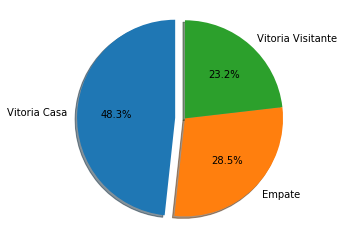

In [310]:
## Porcentagem de vitorias casa/visitante
labels = 'Vitoria Casa', 'Empate', 'Vitoria Visitante'
sizes = list(df_match.result.value_counts())
explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [311]:
groupbyHome(df).agg({"Pontos": ["mean", "std"]})

Pontos          
           mean       std
Home                     
False  2.207859  3.843856
True   3.211663  4.312514

## Home/away players avg performance

In [312]:
df_home_pos = df.groupby(["Home", "Posicao"]).agg({"Pontos": ["mean"]}).reset_index()
df_home_pos

,Home,Posicao,Pontos
,,,mean
0,False,ata,2.093928
1,False,gol,3.360327
2,False,lat,2.674789
3,False,mei,2.023615
4,False,tec,2.745262
5,False,zag,2.183190
6,True,ata,3.144941
7,True,gol,3.946962
8,True,lat,3.949247


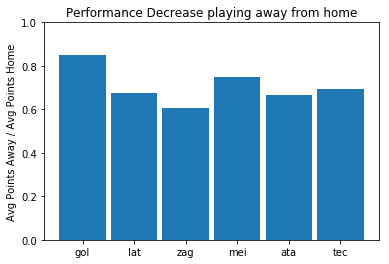

In [423]:
df_home_pos.loc[(df_home_pos.Home == False) & (df_home_pos.Posicao == pos)].Pontos.values[0][0] / df_home_pos.loc[(df_home_pos.Home == True) & (df_home_pos.Posicao == pos)].Pontos.values[0][0]
performance_home = []
for pos in posicoes:
    performance_home.append(df_home_pos.loc[(df_home_pos.Home == False) & (df_home_pos.Posicao == pos)].Pontos.values[0][0] / df_home_pos.loc[(df_home_pos.Home == True) & (df_home_pos.Posicao == pos)].Pontos.values[0][0])
    
ind = np.arange(len(performance_home))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(ind, performance_home, width=0.9)

# add some text for labels, title and axes ticks
ax.set_ylabel('Avg Points Away / Avg Points Home')
ax.set_title('Performance Decrease playing away from home')
ax.set_xticks(ind)
ax.set_xticklabels(posicoes)
ax.set_ylim([0, 1])

plt.show()

In [388]:
def points_sum_casa(series):
    return fp.reduce(lambda x,y: x + 3 if y == 1 else x + 1 if y == 0 else x, series)

def points_sum_fora(series):
    return fp.reduce(lambda x,y: x + 3 if y == -1 else x + 1 if y == 0 else x, series)

def points_count(series):
    return 3 * series.count()

def aproveitamento_casa_fn(series):
    return points_sum(series) / points_count(series)


def aproveitamento_fora_fn(series):
    return points_sum_fora(series) / points_count(series)

In [436]:
df_performance = df.groupby(["ClubeID", "Home"]) \
.agg({"result": [points_sum, points_count, aproveitamento_casa_fn, 
                 aproveitamento_fora_fn], "Pontos": "mean", "home_score": "mean", "away_score": "mean"}).reset_index()
df_performance = df_performance.loc[df_performance.result["points_sum"] != -1]

df_performance

ClubeID   Home     result                                      \
                  points_sum points_count aproveitamento_casa_fn   
0    262.0  False       1580         3069               0.514826   
1    262.0   True       1838         2925               0.628376   
2    263.0  False       1410         2127               0.662906   
3    263.0   True       1174         2145               0.547319   
4    264.0  False       1162         2976               0.390457   
5    264.0   True       2240         2979               0.751930   
6    265.0  False        813         1335               0.608989   
7    265.0   True        577         1344               0.429315   
8    266.0  False       1647         2910               0.565979   
9    266.0   True       1668         2901               0.574974   
10   267.0  False        694         1209               0.574028   
11   267.0   True        614         1383               0.443962   
12   275.0  False       1577         2979               0.529372   
13   275.0   True       1806         2997               0.602603   
14   276.0  False       1705         2976               0.572917   
15   276.0   True       1929         2928               0.658811   
16   277.0  False       1668         2967               0.562184   
17   277.0   True       2198         2985               0.736348   
18   282.0  False       1310         2880               0.454861   
19   282.0   True       1910         2904               0.657713   
20   283.0  False       1497         3045               0.491626   
21   283.0   True       1889         2949               0.640556   
22   284.0  False       1538         2931               0.524736   
23   284.0   True       2112         2988               0.706827   
24   285.0  False       1521         2460               0.618293   
25   285.0   True       1717         2445               0.702249   
26   287.0  False       1300         2181               0.596057   
27   287.0   True        895         2226               0.402066   
32   292.0  False       1864         2832               0.658192   
33   292.0   True       1906         2991               0.637245   
34   293.0  False       1860         2961               0.628166   
35   293.0   True       1947         2979               0.653575   
36   294.0  False       1934         2922               0.661875   
37   294.0   True       1639         3033               0.540389   
38   303.0  False       1305         2142               0.609244   
39   303.0   True       1349         2091               0.645146   
40   314.0  False        901         1296               0.695216   
41   314.0   True        658         1335               0.492884   
42   315.0  False       1762         2859               0.616299   
43   315.0   True       1587         2940               0.539796   
44   316.0  False       1657         2478               0.668684   
45   316.0   True       1171         2406               0.486700   
48   327.0  False        724          846               0.855792   
49   327.0   True        350          795               0.440252   
50   344.0  False        645          837               0.770609   
51   344.0   True        335          795               0.421384   
52   373.0  False        362          477               0.758910   
53   373.0   True        174          528               0.329545   

                             Pontos home_score away_score  
   aproveitamento_fora_fn      mean       mean       mean  
0                0.402411  2.553109   1.339198   0.985337  
1                0.290940  3.527631   1.593846   0.917949  
2                0.273625  2.281044   1.227080   0.633286  
3                0.361305  3.335007   1.398601   1.022378  
4                0.513441  2.879395   1.031250   1.232863  
5                0.167842  3.736475   1.719033   0.652568  
6                0.278652  2.568921   1.373034   0.874157  
7                0.500744  2.860871   1.151786   1.069196  
8 

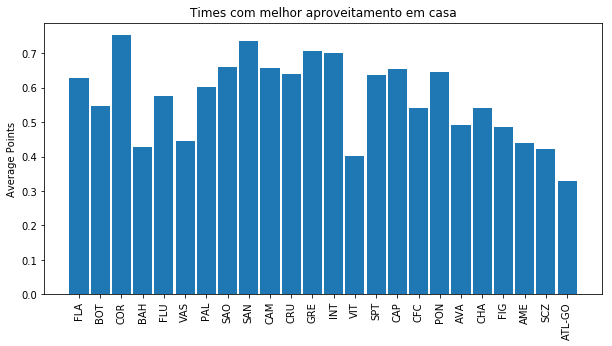

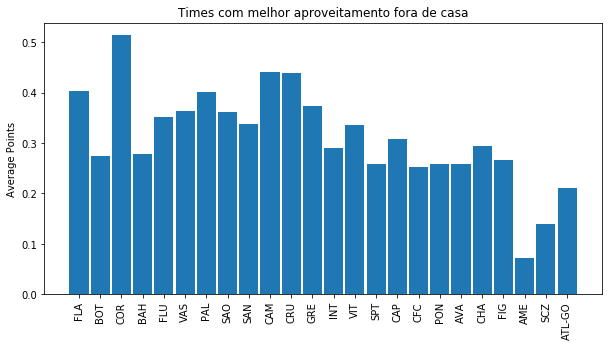

In [431]:
aproveitamento_casa = df_performance.loc[df_performance.Home == True].result.aproveitamento_casa_fn.values
aproveitamento_fora = df_performance.loc[df_performance.Home == False].result.aproveitamento_fora_fn.values
teams = df_performance.loc[df_performance.Home == True].ClubeID.values

ind = np.arange(len(aproveitamento_casa))  # the x locations for the groups
width = 1       # the width of the bars

fig, ax = plt.subplots()

fig.set_size_inches(10, 5)
rects1 = ax.bar(ind, aproveitamento_casa, width=0.9)

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Points')
ax.set_title('Times com melhor aproveitamento em casa')
ax.set_xticks(ind)
ax.set_xticklabels(list(fp.map(lambda key: team_dict[str(int(key))] , teams)), rotation=90)

fig, ax2 = plt.subplots()

fig.set_size_inches(10, 5)
rects1 = ax2.bar(ind, aproveitamento_fora, width=0.9)

# add some text for labels, title and axes ticks
ax2.set_ylabel('Average Points')
ax2.set_title('Times com melhor aproveitamento fora de casa')
ax2.set_xticks(ind)
ax2.set_xticklabels(list(fp.map(lambda key: team_dict[str(int(key))] , teams)), rotation=90)

plt.show()

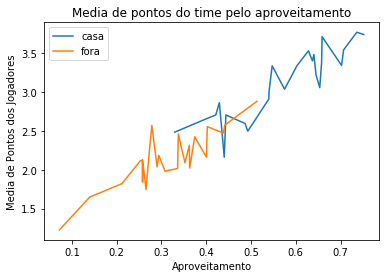

In [399]:
avg_points_home = df_performance.loc[df_performance.Home == True].Pontos["mean"].values
avg_points_away = df_performance.loc[df_performance.Home == False].Pontos["mean"].values

sorted_aproveitamento, sorted_points = zip(*sorted(zip(aproveitamento_casa, avg_points_home), key=lambda x: x[0]))

sorted_aproveitamento_fora, sorted_points_fora = zip(
    *sorted(zip(aproveitamento_fora, avg_points_away), key=lambda x: x[0]))

plt.plot(sorted_aproveitamento, sorted_points, label='casa')
plt.plot(sorted_aproveitamento_fora, sorted_points_fora, label='fora')
plt.title('Media de pontos do time pelo aproveitamento')
plt.xlabel('Aproveitamento')
plt.ylabel('Media de Pontos dos Jogadores')
plt.legend()
plt.show()

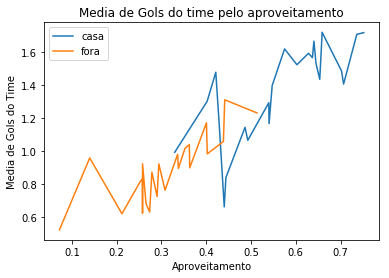

In [437]:
avg_goals_home = df_performance.loc[df_performance.Home == True].home_score["mean"].values
avg_goals_away = df_performance.loc[df_performance.Home == False].away_score["mean"].values

sorted_aproveitamento, sorted_goals = zip(*sorted(zip(aproveitamento_casa, avg_goals_home), key=lambda x: x[0]))

sorted_aproveitamento_fora, sorted_goals_fora = zip(
    *sorted(zip(aproveitamento_fora, avg_goals_away), key=lambda x: x[0]))

plt.plot(sorted_aproveitamento, sorted_goals, label='casa')
plt.plot(sorted_aproveitamento_fora, sorted_goals_fora, label='fora')
plt.title('Media de Gols do time pelo aproveitamento')
plt.xlabel('Aproveitamento')
plt.ylabel('Media de Gols do Time')
plt.legend()
plt.show()

## Media de Pontos e Preço por Posição

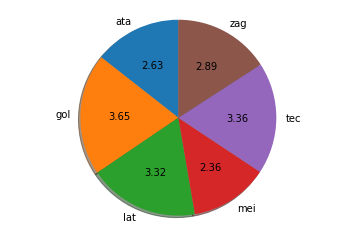

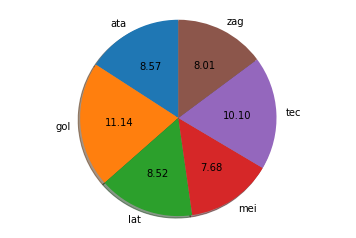

In [438]:
## Porcentagem de Pontos Por posição
df_position = groupbyPosition(df).mean()
## Porcentagem de vitorias casa/visitante
labels = list(df_position.index)
sizes = list(df_position.Pontos)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.2f}'.format(p * sum(sizes) / 100), shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## Porcentagem de Preço Por posição
df_position = groupbyPosition(df).mean()
## Porcentagem de vitorias casa/visitante
labels = list(df_position.index)
sizes = list(df_position.Preco)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.2f}'.format(p * sum(sizes) / 100), shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## Media de Pontos e Preços Top 10 %

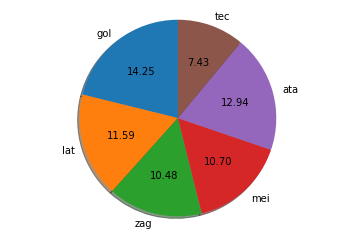

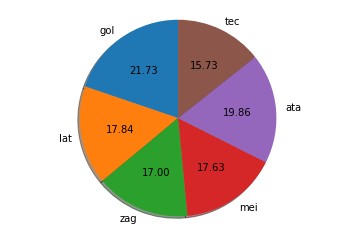

In [148]:
df_sorted = df.sort_values(by=["Pontos"], ascending=False)
avg_points = []
for pos in posicoes:
    temp_df = df_sorted.loc[df_sorted["Posicao"] == pos]
    avg_points.append(groupbyPosition(temp_df.iloc[0:round(0.1 * temp_df.shape[0])]).mean().Pontos.values[0])

## Porcentagem de Pontos Por posição para os top 10 % dos jogadores
df_position = groupbyPosition(df).mean()
## Porcentagem de vitorias casa/visitante
labels = posicoes
sizes = avg_points

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.2f}'.format(p * sum(sizes) / 100), shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


df_sorted = df.sort_values(by=["Preco"], ascending=False)
avg_points = []
for pos in posicoes:
    temp_df = df_sorted.loc[df_sorted["Posicao"] == pos]
    avg_points.append(groupbyPosition(temp_df.iloc[0:round(0.1 * temp_df.shape[0])]).mean().Preco.values[0])

## Porcentagem de Preço Por posição para os top 10 % dos jogadores
df_position = groupbyPosition(df).mean()
## Porcentagem de vitorias casa/visitante
labels = posicoes
sizes = avg_points

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.2f}'.format(p * sum(sizes) / 100), shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Media de Pontos em V/E/D

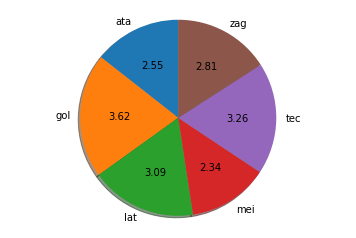

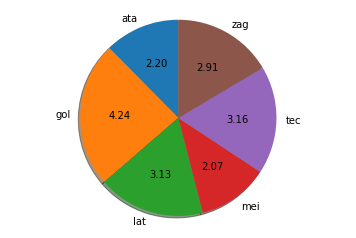

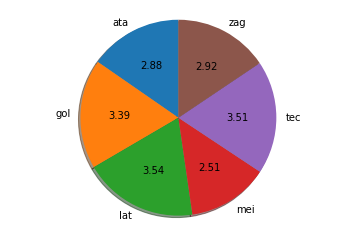

In [418]:
df_wins = df.groupby(["result", "Posicao"]).mean().reset_index()

points_loses = df_wins.loc[((df_wins.result == -1) & (df_wins.Home)) |
                           ((df_wins.result == 1) & (df_wins.Home == False))].Pontos.values
points_draw = df_wins.loc[df_wins.result == 0].Pontos.values
points_wins = df_wins.loc[((df_wins.result == 1) & (df_wins.Home)) |
                           ((df_wins.result == -1) & (df_wins.Home == False))].Pontos.values

plotpizza(points_loses, df_wins.Posicao.unique())
plotpizza(points_draw, df_wins.Posicao.unique())
plotpizza(points_wins, df_wins.Posicao.unique())

In [154]:
groupbyPosition(df).agg({"Pontos" : ["mean", "std"], "Preco" : ["mean", "std"]})

Pontos                Preco          
             mean       std       mean       std
Posicao                                         
ata      2.625055  4.548797   8.572271  5.349067
gol      3.652804  5.696255  11.141817  5.717586
lat      3.315231  4.161203   8.522830  4.551014
mei      2.361334  3.797382   7.677164  4.749674
tec      3.355477  2.105172  10.086365  3.009834
zag      2.888175  3.916888   8.009197  4.441849

## Impacto de Jogadas na pontuação por posição

In [439]:
## Influencia de cada jogada na pontuaçao de cada posiçao
play_points = list(map(lambda jogada: df_position[jogada] * points_dict[jogada], abreviacao))
play_points[0].name
play_names = []
for play in play_points:
    play_names.append(play.name + '_points')
    df_position[play.name + "_points"] = play

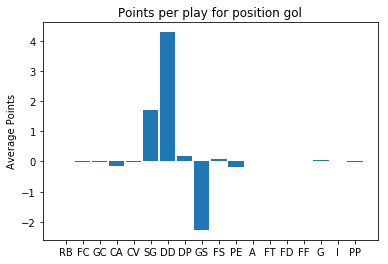

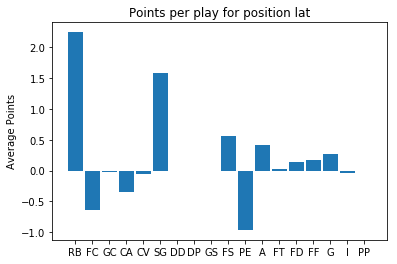

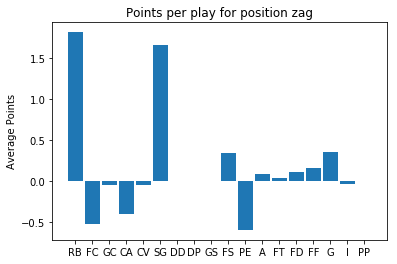

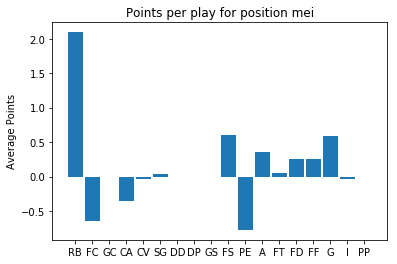

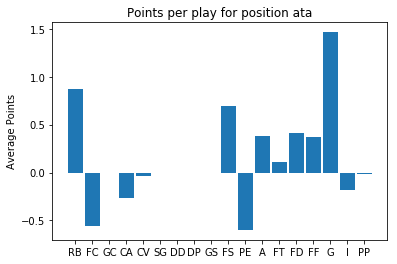

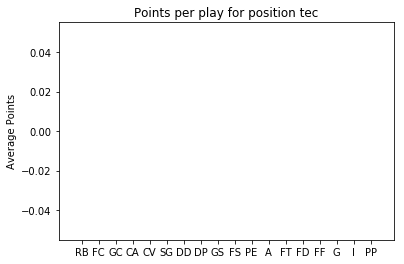

In [440]:


for pos in posicoes:
    ind = np.arange(len(play_names))  # the x locations for the groups
    width = 1       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, df_position.loc[pos][play_names], width=0.9)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Average Points')
    ax.set_title('Points per play for position %s' % pos)
    ax.set_xticks(ind)
    ax.set_xticklabels(abreviacao)

    plt.show()

## Influencia de jogadas em V/D

In [455]:
## Influencia de cada jogada na pontuaçao de cada posiçao

df_wins = df.groupby("result").mean().reset_index()
play_points = list(map(lambda jogada: df_wins[jogada] * points_dict[jogada], abreviacao))
play_points[0].name
play_names = []
for play in play_points:
    play_names.append(play.name + '_points')
    df_wins[play.name + "_points"] = play
    
df_wins

,result,AtletaID,Rodada,Participou,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,...,GS_points,FS_points,PE_points,A_points,FT_points,FD_points,FF_points,G_points,I_points,PP_points
0,-1,66938.294530,18.145889,1.0,12.009855,2.644202,2.726731,7.937768,-0.010516,0.987302,...,-0.164092,0.493651,-0.629435,0.271266,0.054076,0.218611,0.214251,0.608063,-0.065663,-0.008080
1,0,66712.956560,17.894910,1.0,12.543517,2.536335,2.788340,8.287220,-0.050832,0.989030,...,-0.124616,0.494515,-0.644164,0.209522,0.060279,0.217639,0.228291,0.491444,-0.066147,-0.007295
2,1,66581.062861,18.013718,1.0,12.575953,2.832399,2.800445,8.327130,0.030648,0.981131,...,-0.172396,0.490566,-0.634611,0.310890,0.053716,0.214128,0.215526,0.694628,-0.066593,-0.008094


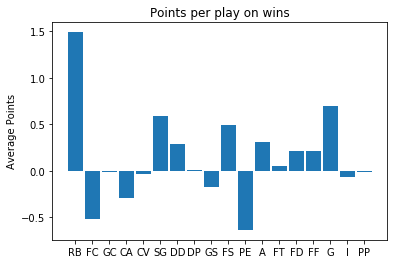

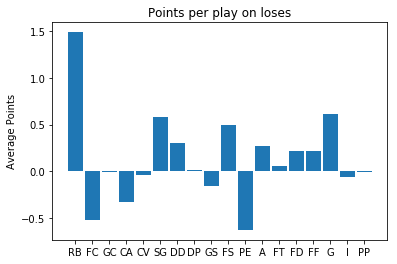

In [457]:
ind = np.arange(len(play_names))  # the x locations for the groups
width = 1       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, df_wins.loc[df_wins.result == 1][play_names].values[0], width=0.9)

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Points')
ax.set_title('Points per play on wins')
ax.set_xticks(ind)
ax.set_xticklabels(abreviacao)

plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(ind, df_wins.loc[df_wins.result == -1][play_names].values[0], width=0.9)

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Points')
ax.set_title('Points per play on loses')
ax.set_xticks(ind)
ax.set_xticklabels(abreviacao)

plt.show()